__Missing Data & Data Imputation__

*Oscar Padilla*

# Introduction
研究在不同缺失模式下，不同缺失比例下，各种缺失插补方法的效果，并且在相同分类器下的分类准确率

The assignment consists of

1. Fit the *Boston House Prices* dataset to a linear regressor. The original dataset has no missing values and the goodness of fit parameters will serve as a baseline

2. Remove (nan) 1%, 5%, 10%, 20%, 33%, and 50% of the data in a single column randomly. Evaluate goodness of fit for each

3. Remove (nan) 10%, 20%, 30% of the data of two columns randomly but based on the value of a third column. Evaluate goodness of fit for each

4. Remove (nan) 25% of the data not at random but based on a pattern. Evaluate goodness of fit and compare all of the above to the baseline

# Background

Let's understand the original dataset

## Boston House Prices Dataset

In [2]:
%matplotlib inline 

import numpy as np
import pandas as pd
import copy
import scipy.stats as stats
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm
import random
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

# special matplotlib argument for improved plots
from matplotlib import rcParams

In [3]:
from ycimpute.utils import evaluate
from matplotlib import pyplot as plt
from utils.handle_missingdata import gene_missingdata
from dnn.mida import MIDA
from dnn.gain import GAIN
from ycimpute.imputer import knnimput, mice, EM
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler, SimpleFill

Using TensorFlow backend.


In [4]:
from sklearn.datasets import load_boston
boston = load_boston()
print(boston.data.shape)

(506, 13)


In [5]:
print(boston.DESCR)

.. _boston_dataset:

Boston house prices dataset
---------------------------

**Data Set Characteristics:**  

    :Number of Instances: 506 

    :Number of Attributes: 13 numeric/categorical predictive. Median Value (attribute 14) is usually the target.

    :Attribute Information (in order):
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pu

In [6]:
bos = pd.DataFrame(boston.data)
bos.columns = boston.feature_names
bos['PRICE'] = boston.target
bos.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21,28.7
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15,27.1
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93,16.5
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10,18.9


In [7]:
bos.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,PRICE
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063,22.532806
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062,9.197104
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000,5.000000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000,17.025000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000,21.200000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000,25.000000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000,50.000000


The initial high-level review demonstrate there are no missing data in the original dataset

# Methods

The approach for this time study is to first establish the goodness of fit baseline with the original dataset. We will use the $R^2$ score and the root-mean-square-error $RMSE_0$ as our comparison metrics throughout all experiments

## Linear Regression Baseline

In [8]:
X = bos.drop('PRICE', axis = 1)
Y = bos['PRICE']

In [9]:
lm = LinearRegression()
lm.fit(X, Y)

predictions = lm.predict(X)

R2_0 = lm.score(X, Y)
R2_0

0.7406426641094095

In [10]:
mse = sklearn.metrics.mean_squared_error(predictions, Y)
RMSE0 = math.sqrt(mse)
RMSE0

4.679191295697281

## Missing at Random

Function created to select values at random within the percent threshold (i.e. *impute factor*) and then to impute those missing values with the `mean`

In [11]:
def missing_at_random(rate,data,seed=0):
    '''
    :param rate: 缺失率，int
    :param data: 完整数据集，df
    随机模式缺失
    :return:缺失后数据集和缺失行数
    '''
    random.seed=seed
    count=0
    miss_data=data.copy()
    nrow,ncol=miss_data.shape
    while count<rate*nrow*ncol:
        row=int(random.random()*nrow)
        col=int(random.random()*ncol)
        if miss_data.iloc[row,col]!=np.nan:
            miss_data.iloc[row,col]=np.nan
            count+=1
    return miss_data

In [12]:
import impyute
from ycimpute.utils import evaluate
from matplotlib import pyplot as plt
from utils.handle_missingdata import gene_missingdata
from dnn.mida import MIDA
from dnn.gain import GAIN
from ycimpute.imputer import knnimput, mice, EM, GAIN
from fancyimpute import KNN, NuclearNormMinimization, SoftImpute, IterativeImputer, BiScaler, SimpleFill

### Impute Factor = 5%

In [13]:
X01 = missing_at_random(0.05,X)
X01.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,NaN,0.0,0.538,6.575,NaN,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,NaN,6.0622,3.0,222.0,18.7,396.90,5.33
5,NaN,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,NaN
6,0.08829,12.5,7.87,NaN,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,NaN
7,0.14455,NaN,7.87,0.0,0.524,6.172,96.1,NaN,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [14]:
X01.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,487.000000,483.000000,479.000000,483.000000,478.000000,482.000000,482.000000,484.000000,484.000000,481.000000,487.000000,482.000000,471.000000
mean,3.607411,10.955487,11.193695,0.068323,0.553499,6.278064,68.659959,3.768042,9.464876,405.386694,18.431006,356.087718,12.618259
std,8.672807,22.639530,6.832932,0.252561,0.116475,0.708540,28.220236,2.078878,8.654443,166.954211,2.150673,92.330843,7.080016
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082865,0.000000,5.190000,0.000000,0.448000,5.881000,44.550000,2.097050,4.000000,279.000000,17.350000,375.240000,7.130000
50%,0.253870,0.000000,9.690000,0.000000,0.532000,6.189000,77.750000,3.190950,5.000000,330.000000,18.900000,391.340000,11.380000
75%,3.675945,12.500000,18.100000,0.000000,0.624000,6.613500,94.100000,5.117025,24.000000,666.000000,20.200000,396.225000,16.820000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,36.980000


In [15]:
X01=X01.values

In [16]:
#传统机器学习最好的方法
imputed_data0_0 = mice.MICE().complete(X01)
score0_0 = evaluate.RMSE(X, imputed_data0_0)
imputed_data0_1 = IterativeImputer().fit_transform(X01)
score0_0 = evaluate.RMSE(X, imputed_data0_1)
#古生物中最常用插补方法
imputed_data1_0 = impyute.imputation.cs.random(X01)
score1_0 = evaluate.RMSE(X, imputed_data1_0)
imputed_data1_1 = SimpleFill("median").fit_transform(X01)
score1_0 = evaluate.RMSE(X, imputed_data1_1)
#深度学习方法，在某些缺失模式下效果较传统方法会更好
imputed_data2_0 = MIDA().complete(X01)
score2_0 = evaluate.RMSE(X, imputed_data2_0)
imputed_data2_1 = GAIN().complete(X01)
score2_0 = evaluate.RMSE(origin_data, imputed_data2_0)

f:\mini_conda\envs\gat-tsp\lib\site-packages\sklearn\impute\_iterative.py:670: ConvergenceWarning: [IterativeImputer] Early stopping criterion not reached.
  " reached.", ConvergenceWarning)


Epoch [1/300], lter [2/4], Loss: 0.375485
Epoch [1/300], lter [4/4], Loss: 0.346246
Epoch [2/300], lter [2/4], Loss: 0.310055
Epoch [2/300], lter [4/4], Loss: 0.278964
Epoch [3/300], lter [2/4], Loss: 0.203277
Epoch [3/300], lter [4/4], Loss: 0.174708
Epoch [4/300], lter [2/4], Loss: 0.111803
Epoch [4/300], lter [4/4], Loss: 0.106609
Epoch [5/300], lter [2/4], Loss: 0.071039
Epoch [5/300], lter [4/4], Loss: 0.069681
Epoch [6/300], lter [2/4], Loss: 0.058993
Epoch [6/300], lter [4/4], Loss: 0.049394
Epoch [7/300], lter [2/4], Loss: 0.048429
Epoch [7/300], lter [4/4], Loss: 0.044991
Epoch [8/300], lter [2/4], Loss: 0.043005
Epoch [8/300], lter [4/4], Loss: 0.044897
Epoch [9/300], lter [2/4], Loss: 0.042430
Epoch [9/300], lter [4/4], Loss: 0.048604
Epoch [10/300], lter [2/4], Loss: 0.049927
Epoch [10/300], lter [4/4], Loss: 0.039334
Epoch [11/300], lter [2/4], Loss: 0.039670
Epoch [11/300], lter [4/4], Loss: 0.044676
Epoch [12/300], lter [2/4], Loss: 0.049566
Epoch [12/300], lter [4/4], L

Epoch [105/300], lter [2/4], Loss: 0.014419
Epoch [105/300], lter [4/4], Loss: 0.017343
Epoch [106/300], lter [2/4], Loss: 0.018580
Epoch [106/300], lter [4/4], Loss: 0.015827
Epoch [107/300], lter [2/4], Loss: 0.015711
Epoch [107/300], lter [4/4], Loss: 0.018776
Epoch [108/300], lter [2/4], Loss: 0.013304
Epoch [108/300], lter [4/4], Loss: 0.020504
Epoch [109/300], lter [2/4], Loss: 0.016764
Epoch [109/300], lter [4/4], Loss: 0.017025
Epoch [110/300], lter [2/4], Loss: 0.016852
Epoch [110/300], lter [4/4], Loss: 0.017305
Epoch [111/300], lter [2/4], Loss: 0.016018
Epoch [111/300], lter [4/4], Loss: 0.017750
Epoch [112/300], lter [2/4], Loss: 0.019453
Epoch [112/300], lter [4/4], Loss: 0.018250
Epoch [113/300], lter [2/4], Loss: 0.021108
Epoch [113/300], lter [4/4], Loss: 0.015270
Epoch [114/300], lter [2/4], Loss: 0.016518
Epoch [114/300], lter [4/4], Loss: 0.015957
Epoch [115/300], lter [2/4], Loss: 0.014659
Epoch [115/300], lter [4/4], Loss: 0.016180
Epoch [116/300], lter [2/4], Los

Epoch [213/300], lter [4/4], Loss: 0.010296
Epoch [214/300], lter [2/4], Loss: 0.012696
Epoch [214/300], lter [4/4], Loss: 0.009683
Epoch [215/300], lter [2/4], Loss: 0.015994
Epoch [215/300], lter [4/4], Loss: 0.011005
Epoch [216/300], lter [2/4], Loss: 0.011557
Epoch [216/300], lter [4/4], Loss: 0.010281
Epoch [217/300], lter [2/4], Loss: 0.010588
Epoch [217/300], lter [4/4], Loss: 0.015048
Epoch [218/300], lter [2/4], Loss: 0.013543
Epoch [218/300], lter [4/4], Loss: 0.009400
Epoch [219/300], lter [2/4], Loss: 0.012982
Epoch [219/300], lter [4/4], Loss: 0.011696
Epoch [220/300], lter [2/4], Loss: 0.014790
Epoch [220/300], lter [4/4], Loss: 0.015646
Epoch [221/300], lter [2/4], Loss: 0.013326
Epoch [221/300], lter [4/4], Loss: 0.013529
Epoch [222/300], lter [2/4], Loss: 0.010899
Epoch [222/300], lter [4/4], Loss: 0.011589
Epoch [223/300], lter [2/4], Loss: 0.015290
Epoch [223/300], lter [4/4], Loss: 0.012198
Epoch [224/300], lter [2/4], Loss: 0.012076
Epoch [224/300], lter [4/4], Los

f:\mini_conda\envs\gat-tsp\lib\site-packages\ycimpute-0.2-py3.6.egg\ycimpute\imputer\gain.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
f:\mini_conda\envs\gat-tsp\lib\site-packages\ycimpute-0.2-py3.6.egg\ycimpute\imputer\gain.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
f:\mini_conda\envs\gat-tsp\lib\site-packages\torch\nn\_reduction.py:15: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Iter:0	D_loss: 0.5057	G_loss: 0.0225	Train MSE:0.3320
Iter:0	D_loss: 0.5001	G_loss: 0.0273	Train MSE:0.3661
Iter:0	D_loss: 0.4947	G_loss: 0.0265	Train MSE:0.3610
Iter:0	D_loss: 0.4953	G_loss: 0.0273	Train MSE:0.3665
Iter:0	D_loss: 0.4935	G_loss: 0.0207	Train MSE:0.3179
Iter:0	D_loss: 0.5070	G_loss: 0.0279	Train MSE:0.3703
Iter:0	D_loss: 0.4797	G_loss: 0.0364	Train MSE:0.4241
Iter:0	D_loss: 0.5023	G_loss: 0.0294	Train MSE:0.3806
Iter:2	D_loss: 0.5254	G_loss: 0.0200	Train MSE:0.3124
Iter:2	D_loss: 0.4870	G_loss: 0.0239	Train MSE:0.3421
Iter:2	D_loss: 0.4950	G_loss: 0.0259	Train MSE:0.3569
Iter:2	D_loss: 0.4931	G_loss: 0.0227	Train MSE:0.3335
Iter:2	D_loss: 0.4974	G_loss: 0.0187	Train MSE:0.3021
Iter:2	D_loss: 0.5070	G_loss: 0.0322	Train MSE:0.3985
Iter:2	D_loss: 0.4956	G_loss: 0.0340	Train MSE:0.4095
Iter:2	D_loss: 0.4926	G_loss: 0.0266	Train MSE:0.3625
Iter:4	D_loss: 0.5101	G_loss: 0.0266	Train MSE:0.3613
Iter:4	D_loss: 0.5008	G_loss: 0.0284	Train MSE:0.3737
Iter:4	D_loss: 0.4958	G_loss

NameError: name 'origin_data' is not defined

In [ ]:
lm.fit(imputed_data0_0, Y)
predictions = lm.predict(imputed_data0_0)
R2_0_0 = lm.score(imputed_data0_0, Y)
RMSE0_0=sklearn.metrics.mean_squared_error(imputed_data0_0,X)
YRMSE0_0 = sklearn.metrics.mean_squared_error(predictions, Y)
print("R2: ",R2_0_0)
print("RMSE: ",RMSE0_0)
print("YRMSE: ",YRMSE0_0)

Epoch [1/300], lter [2/4], Loss: 0.333185
Epoch [1/300], lter [4/4], Loss: 0.310813
Epoch [2/300], lter [2/4], Loss: 0.272330
Epoch [2/300], lter [4/4], Loss: 0.240154
Epoch [3/300], lter [2/4], Loss: 0.192710
Epoch [3/300], lter [4/4], Loss: 0.151590
Epoch [4/300], lter [2/4], Loss: 0.104124
Epoch [4/300], lter [4/4], Loss: 0.080862
Epoch [5/300], lter [2/4], Loss: 0.065903
Epoch [5/300], lter [4/4], Loss: 0.067287
Epoch [6/300], lter [2/4], Loss: 0.056890
Epoch [6/300], lter [4/4], Loss: 0.045590
Epoch [7/300], lter [2/4], Loss: 0.045577
Epoch [7/300], lter [4/4], Loss: 0.051616
Epoch [8/300], lter [2/4], Loss: 0.046834
Epoch [8/300], lter [4/4], Loss: 0.045269
Epoch [9/300], lter [2/4], Loss: 0.044969
Epoch [9/300], lter [4/4], Loss: 0.051742
Epoch [10/300], lter [2/4], Loss: 0.047271
Epoch [10/300], lter [4/4], Loss: 0.048206
Epoch [11/300], lter [2/4], Loss: 0.043941
Epoch [11/300], lter [4/4], Loss: 0.044533
Epoch [12/300], lter [2/4], Loss: 0.042526
Epoch [12/300], lter [4/4], L

Epoch [101/300], lter [2/4], Loss: 0.021474
Epoch [101/300], lter [4/4], Loss: 0.017717
Epoch [102/300], lter [2/4], Loss: 0.019555
Epoch [102/300], lter [4/4], Loss: 0.019714
Epoch [103/300], lter [2/4], Loss: 0.020711
Epoch [103/300], lter [4/4], Loss: 0.016427
Epoch [104/300], lter [2/4], Loss: 0.016614
Epoch [104/300], lter [4/4], Loss: 0.021899
Epoch [105/300], lter [2/4], Loss: 0.017372
Epoch [105/300], lter [4/4], Loss: 0.016135
Epoch [106/300], lter [2/4], Loss: 0.017853
Epoch [106/300], lter [4/4], Loss: 0.020850
Epoch [107/300], lter [2/4], Loss: 0.018971
Epoch [107/300], lter [4/4], Loss: 0.018872
Epoch [108/300], lter [2/4], Loss: 0.020440
Epoch [108/300], lter [4/4], Loss: 0.019173
Epoch [109/300], lter [2/4], Loss: 0.019636
Epoch [109/300], lter [4/4], Loss: 0.019533
Epoch [110/300], lter [2/4], Loss: 0.020641
Epoch [110/300], lter [4/4], Loss: 0.019289
Epoch [111/300], lter [2/4], Loss: 0.018450
Epoch [111/300], lter [4/4], Loss: 0.018922
Epoch [112/300], lter [2/4], Los

Epoch [204/300], lter [2/4], Loss: 0.012625
Epoch [204/300], lter [4/4], Loss: 0.013531
Epoch [205/300], lter [2/4], Loss: 0.014685
Epoch [205/300], lter [4/4], Loss: 0.009522
Epoch [206/300], lter [2/4], Loss: 0.012209
Epoch [206/300], lter [4/4], Loss: 0.009527
Epoch [207/300], lter [2/4], Loss: 0.014736
Epoch [207/300], lter [4/4], Loss: 0.013014
Epoch [208/300], lter [2/4], Loss: 0.013631
Epoch [208/300], lter [4/4], Loss: 0.013548
Epoch [209/300], lter [2/4], Loss: 0.011143
Epoch [209/300], lter [4/4], Loss: 0.012164
Epoch [210/300], lter [2/4], Loss: 0.013379
Epoch [210/300], lter [4/4], Loss: 0.015288
Epoch [211/300], lter [2/4], Loss: 0.015750
Epoch [211/300], lter [4/4], Loss: 0.009621
Epoch [212/300], lter [2/4], Loss: 0.011243
Epoch [212/300], lter [4/4], Loss: 0.013778
Epoch [213/300], lter [2/4], Loss: 0.012964
Epoch [213/300], lter [4/4], Loss: 0.012704
Epoch [214/300], lter [2/4], Loss: 0.011015
Epoch [214/300], lter [4/4], Loss: 0.013048
Epoch [215/300], lter [2/4], Los

f:\mini_conda\envs\gat-tsp\lib\site-packages\ycimpute-0.2-py3.6.egg\ycimpute\imputer\gain.py:90: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
f:\mini_conda\envs\gat-tsp\lib\site-packages\ycimpute-0.2-py3.6.egg\ycimpute\imputer\gain.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
f:\mini_conda\envs\gat-tsp\lib\site-packages\torch\nn\_reduction.py:15: UserWarning: reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.
  warnings.warn("reduction='elementwise_mean' is deprecated, please use reduction='mean' instead.")


Iter:0	D_loss: 0.4984	G_loss: 0.0232	Train MSE:0.3369
Iter:0	D_loss: 0.4915	G_loss: 0.0227	Train MSE:0.3336
Iter:0	D_loss: 0.5052	G_loss: 0.0245	Train MSE:0.3465
Iter:0	D_loss: 0.4989	G_loss: 0.0242	Train MSE:0.3445
Iter:0	D_loss: 0.5068	G_loss: 0.0231	Train MSE:0.3367
Iter:0	D_loss: 0.4985	G_loss: 0.0285	Train MSE:0.3747
Iter:0	D_loss: 0.4948	G_loss: 0.0333	Train MSE:0.4052
Iter:0	D_loss: 0.5016	G_loss: 0.0256	Train MSE:0.3546
Iter:2	D_loss: 0.4940	G_loss: 0.0250	Train MSE:0.3504
Iter:2	D_loss: 0.4938	G_loss: 0.0258	Train MSE:0.3561
Iter:2	D_loss: 0.5083	G_loss: 0.0268	Train MSE:0.3627
Iter:2	D_loss: 0.5003	G_loss: 0.0209	Train MSE:0.3201
Iter:2	D_loss: 0.5070	G_loss: 0.0207	Train MSE:0.3185
Iter:2	D_loss: 0.4890	G_loss: 0.0302	Train MSE:0.3854
Iter:2	D_loss: 0.4864	G_loss: 0.0299	Train MSE:0.3837
Iter:2	D_loss: 0.4991	G_loss: 0.0266	Train MSE:0.3617
Iter:4	D_loss: 0.4986	G_loss: 0.0249	Train MSE:0.3497
Iter:4	D_loss: 0.4945	G_loss: 0.0249	Train MSE:0.3496
Iter:4	D_loss: 0.4934	G_loss

NameError: name 'origin_data' is not defined

In [26]:
lm.fit(imputed_data0_0, Y)
predictions = lm.predict(imputed_data0_0)
R2_0_0 = lm.score(imputed_data0_0, Y)
RMSE0_0=sklearn.metrics.mean_squared_error(imputed_data0_0,X)
YRMSE0_0 = sklearn.metrics.mean_squared_error(predictions, Y)
print("R2: ",R2_0_0)
print("RMSE: ",RMSE0_0)
print("YRMSE: ",YRMSE0_0)

R2:  0.7298479474683381
RMSE:  36.53092189352022
YRMSE:  22.80611636940001


In [12]:
mse01 = sklearn.metrics.mean_squared_error(predictions01, Y)
RMSE01 = math.sqrt(mse01)
RMSE01

0.7406484641457269

In [13]:
mse01 = sklearn.metrics.mean_squared_error(predictions01, Y)
RMSE01 = math.sqrt(mse01)
RMSE01

4.679138974772773

### Impute Factor = 5%

In [14]:
X05 = missing_at_random(X, 0.05, 'AGE')
X05.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [15]:
X05.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.626884,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,27.617780,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.800000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,76.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,93.600000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [16]:
lm.fit(X05, Y)

predictions05 = lm.predict(X05)

R2_05 = lm.score(X05, Y)
R2_05

0.7408140628510695

In [17]:
mse05 = sklearn.metrics.mean_squared_error(predictions05, Y)
RMSE05 = math.sqrt(mse05)
RMSE05

4.67764489631615

### Impute Factor = 10%

In [18]:
X10 = missing_at_random(X, 0.10, 'AGE')
X10.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,68.676549,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,68.676549,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.100000,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.800000,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200000,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.700000,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,68.676549,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.100000,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.000000,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.900000,6.5921,5.0,311.0,15.2,386.71,17.10


In [19]:
X10.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.676549,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,26.516223,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,49.150000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,70.350000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,93.450000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [20]:
lm.fit(X10, Y)

predictions10 = lm.predict(X10)

R2_10 = lm.score(X10, Y)
R2_10

0.740725066440148

In [21]:
mse10 = sklearn.metrics.mean_squared_error(predictions10, Y)
RMSE10 = math.sqrt(mse10)
RMSE10

4.67844790646877

### Impute Factor = 20%

In [22]:
X20 = missing_at_random(X, 0.20, 'AGE')
X20.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [23]:
X20.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.177444,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,25.322682,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,53.850000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,68.177444,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,91.000000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [24]:
lm.fit(X20, Y)

predictions20 = lm.predict(X20)

R2_20 = lm.score(X20, Y)
R2_20

0.7407449891823574

In [25]:
mse20 = sklearn.metrics.mean_squared_error(predictions20, Y)
RMSE20 = math.sqrt(mse20)
RMSE20

4.67826815653905

### Impute Factor = 33%

In [26]:
X33 = missing_at_random(X, 0.33, 'AGE')
X33.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.200000,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900000,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.100000,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.800000,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.200000,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,67.939733,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.600000,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.100000,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.000000,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,67.939733,6.5921,5.0,311.0,15.2,386.71,17.10


In [27]:
X33.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,67.939733,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,24.767217,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,54.750000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,67.939733,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,89.975000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [28]:
lm.fit(X33, Y)

predictions33 = lm.predict(X33)

R2_33 = lm.score(X33, Y)
R2_33

0.7411342770527445

In [29]:
mse33 = sklearn.metrics.mean_squared_error(predictions33, Y)
RMSE33 = math.sqrt(mse33)
RMSE33

4.674754478606576

### Impute Factor = 50%

In [30]:
X50 = missing_at_random(X, 0.50, 'AGE')
X50.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,66.749398,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.900000,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,66.749398,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.800000,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,66.749398,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.700000,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.749398,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.100000,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,66.749398,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.900000,6.5921,5.0,311.0,15.2,386.71,17.10


In [31]:
X50.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,66.749398,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,20.066910,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,66.749398,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,66.749398,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,74.450000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [32]:
lm.fit(X50, Y)

predictions50 = lm.predict(X50)

R2_50 = lm.score(X50, Y)
R2_50

0.7407247956501855

In [33]:
mse50 = sklearn.metrics.mean_squared_error(predictions50, Y)
RMSE50 = math.sqrt(mse50)
RMSE50

4.678450349582699

## Missing at Random when Controlled for a Third Variable

Function created to select values from two columns at random within the percent threshold (i.e. *impute factor*) but controlled by a third variable, i.e. *control variable* (when third variable meets certain criteria). Impute missing values with the `mean`

In [34]:
def mar_thirdcontrol(df_orig, imp_factor, control_factor, first, second, third):
    df = copy.deepcopy(df_orig)
    imp1_column = df[[first]]
    imp2_column = df[[second]]
    imp1_column = np.where((np.random.random(imp1_column.shape) < imp_factor) & (df[[third]] <  control_factor), np.nan, imp1_column)
    imp2_column = np.where((np.random.random(imp2_column.shape) < imp_factor) & (df[[third]] <  control_factor), np.nan, imp2_column)
    new_df = pd.DataFrame(index = df.index, columns = df.columns) #declare new_df
    new_df = new_df.fillna(0) #empty
    new_df.drop(new_df.index, inplace=True) #reset
    new_df = df
    new_df[first] = imp1_column
    new_df[second] = imp2_column
    new_df.fillna(new_df.mean(), inplace=True)
    return new_df

### Impute Factor = 10%

*Control variable* = `LSTAT`
*Control factor* = 12.65
*Imputed variables* = `NOX` & `RM`

In other words, when `LSTAT` < 12.65 then ~ 10% of the data of `NOX` & `RM` will be imputed

In [35]:
Xthird10 = mar_thirdcontrol(X, 0.10, 12.65, 'NOX', 'RM', 'LSTAT')
Xthird10.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.559417,6.575000,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469000,6.421000,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469000,7.185000,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458000,6.998000,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458000,6.258773,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458000,6.430000,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524000,6.012000,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524000,6.172000,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524000,5.631000,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524000,6.004000,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [36]:
Xthird10.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.559417,6.258773,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.112674,0.664334,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.464000,5.888250,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.547000,6.229000,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.561250,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [37]:
lm.fit(Xthird10, Y)

predictionsthird10 = lm.predict(Xthird10)

R2_third10 = lm.score(Xthird10, Y)
R2_third10

0.7263377286207957

In [38]:
msethird10 = sklearn.metrics.mean_squared_error(predictionsthird10, Y)
RMSEthird10 = math.sqrt(msethird10)
RMSEthird10

4.8065005447332

### Impute Factor = 20%

In [39]:
Xthird20 = mar_thirdcontrol(X, 0.20, 12.65, 'NOX', 'RM', 'LSTAT')
Xthird20.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538000,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469000,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469000,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458000,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458000,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458000,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.562898,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524000,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524000,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524000,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [40]:
Xthird20.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.562898,6.247520,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.109102,0.657168,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.488000,5.901750,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.562898,6.247520,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.489250,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [41]:
lm.fit(Xthird20, Y)

predictionsthird20 = lm.predict(Xthird20)

R2_third20 = lm.score(Xthird20, Y)
R2_third20

0.719210441408614

In [42]:
msethird20 = sklearn.metrics.mean_squared_error(predictionsthird20, Y)
RMSEthird20 = math.sqrt(msethird20)
RMSEthird20

4.868688725886104

### Impute Factor = 30%

In [43]:
Xthird30 = mar_thirdcontrol(X, 0.30, 12.65, 'NOX', 'RM', 'LSTAT')
Xthird30.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.21
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,19.15
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,29.93
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,17.10


In [44]:
Xthird30.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.567072,6.202282,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,12.653063
std,8.601545,23.322453,6.860353,0.253994,0.107133,0.611067,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,7.141062
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.489000,5.913250,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.567072,6.202282,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,11.360000
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.433750,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,16.955000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,37.970000


In [45]:
lm.fit(Xthird30, Y)

predictionsthird30 = lm.predict(Xthird30)

R2_third30 = lm.score(Xthird30, Y)
R2_third30

0.6987682226305575

In [46]:
msethird30 = sklearn.metrics.mean_squared_error(predictionsthird30, Y)
RMSEthird30 = math.sqrt(msethird30)
RMSEthird30

5.042802092652577

## Missing Not at Random

When column `LSTAT` is greater than 16.955 (third quartile) values are removed (nan) and imputed by their mean.

In [47]:
def missing_not_at_random(df_orig, control_factor, col):
    df = copy.deepcopy(df_orig)
    imp_column = df[[col]]
    imp_column = np.where(df[[col]] >  control_factor, np.nan, imp_column)
    new_df = pd.DataFrame(index = df.index, columns = df.columns) #declare new_df
    new_df = new_df.fillna(0) #empty
    new_df.drop(new_df.index, inplace=True) #reset
    new_df = df
    new_df[col] = imp_column
    new_df.fillna(new_df.mean(), inplace=True)
    return new_df

In [48]:
XMNAR = missing_not_at_random(X, 16.955000, 'LSTAT')
XMNAR.head(12)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.980000
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.140000
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.030000
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.940000
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.330000
5,0.02985,0.0,2.18,0.0,0.458,6.430,58.7,6.0622,3.0,222.0,18.7,394.12,5.210000
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.430000
7,0.14455,12.5,7.87,0.0,0.524,6.172,96.1,5.9505,5.0,311.0,15.2,396.90,9.325356
8,0.21124,12.5,7.87,0.0,0.524,5.631,100.0,6.0821,5.0,311.0,15.2,386.63,9.325356
9,0.17004,12.5,7.87,0.0,0.524,6.004,85.9,6.5921,5.0,311.0,15.2,386.71,9.325356


In [49]:
XMNAR.describe()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,3.613524,11.363636,11.136779,0.069170,0.554695,6.284634,68.574901,3.795043,9.549407,408.237154,18.455534,356.674032,9.325356
std,8.601545,23.322453,6.860353,0.253994,0.115878,0.702617,28.148861,2.105710,8.707259,168.537116,2.164946,91.294864,3.399196
min,0.006320,0.000000,0.460000,0.000000,0.385000,3.561000,2.900000,1.129600,1.000000,187.000000,12.600000,0.320000,1.730000
25%,0.082045,0.000000,5.190000,0.000000,0.449000,5.885500,45.025000,2.100175,4.000000,279.000000,17.400000,375.377500,6.950000
50%,0.256510,0.000000,9.690000,0.000000,0.538000,6.208500,77.500000,3.207450,5.000000,330.000000,19.050000,391.440000,9.325356
75%,3.677083,12.500000,18.100000,0.000000,0.624000,6.623500,94.075000,5.188425,24.000000,666.000000,20.200000,396.225000,11.335000
max,88.976200,100.000000,27.740000,1.000000,0.871000,8.780000,100.000000,12.126500,24.000000,711.000000,22.000000,396.900000,16.940000


In [50]:
lm.fit(XMNAR, Y)

predictionsMNAR = lm.predict(XMNAR)

R2_MNAR = lm.score(XMNAR, Y)
R2_MNAR

0.7083301513934981

In [51]:
mseMNAR = sklearn.metrics.mean_squared_error(predictionsMNAR, Y)
RMSEMNAR = math.sqrt(mseMNAR)
RMSEMNAR

4.9621204301686275

# Results

Let's summarize all result from all the experiments above in one dataframe that contains the *imputation factor* and the type of imputation and their effects on $R^2$ and $RMSE$

In [63]:
r = {'Imputation Factor' : [0, 0.01, 0.05, 0.10, 0.10, 0.20, 0.20, 0.25, 0.30, 0.33, 0.50],
     'Type': ['Baseline', 'MAR', 'MAR', 'MAR', 'Third', 'MAR', 'Third', 'MNAR', 'Third', 'MAR', 'MAR'],
     'R2' : [R2_0, R2_01, R2_05, R2_10, R2_third10, R2_20, R2_third20, R2_MNAR, R2_third30, R2_33, R2_50],
     'RMSE': [RMSE0, RMSE01, RMSE05, RMSE10, RMSEthird10, RMSE20, RMSEthird20, RMSEMNAR, RMSEthird30, RMSE33, RMSE50]
    }

results = pd.DataFrame(data = r)

results

,Imputation Factor,Type,R2,RMSE
0,0.00,Baseline,0.740643,4.679191
1,0.01,MAR,0.740648,4.679139
2,0.05,MAR,0.740814,4.677645
3,0.10,MAR,0.740725,4.678448
4,0.10,Third,0.726338,4.806501
5,0.20,MAR,0.740745,4.678268
6,0.20,Third,0.719210,4.868689
7,0.25,MNAR,0.708330,4.962120
8,0.30,Third,0.698768,5.042802
9,0.33,MAR,0.741134,4.674754


# Conclusion

Results clearly show that on both measures ($R^2$ and $RMSE$), the *imputation factor* (i.e. the percentage of values replaced with `nan` and then imputed with the mean) has negligible influence when values are Missing at Random (MAR).
On the other hand, the *imputation type* has a dramatic effect. When data is Missing Not at Random (MNAR), the linear regressor goodness-of-fit deteriorates as function of the *imputation factor*. It's surprising that the same deterioration occurs when missing data is not 100% random but controlled by a Third variable.

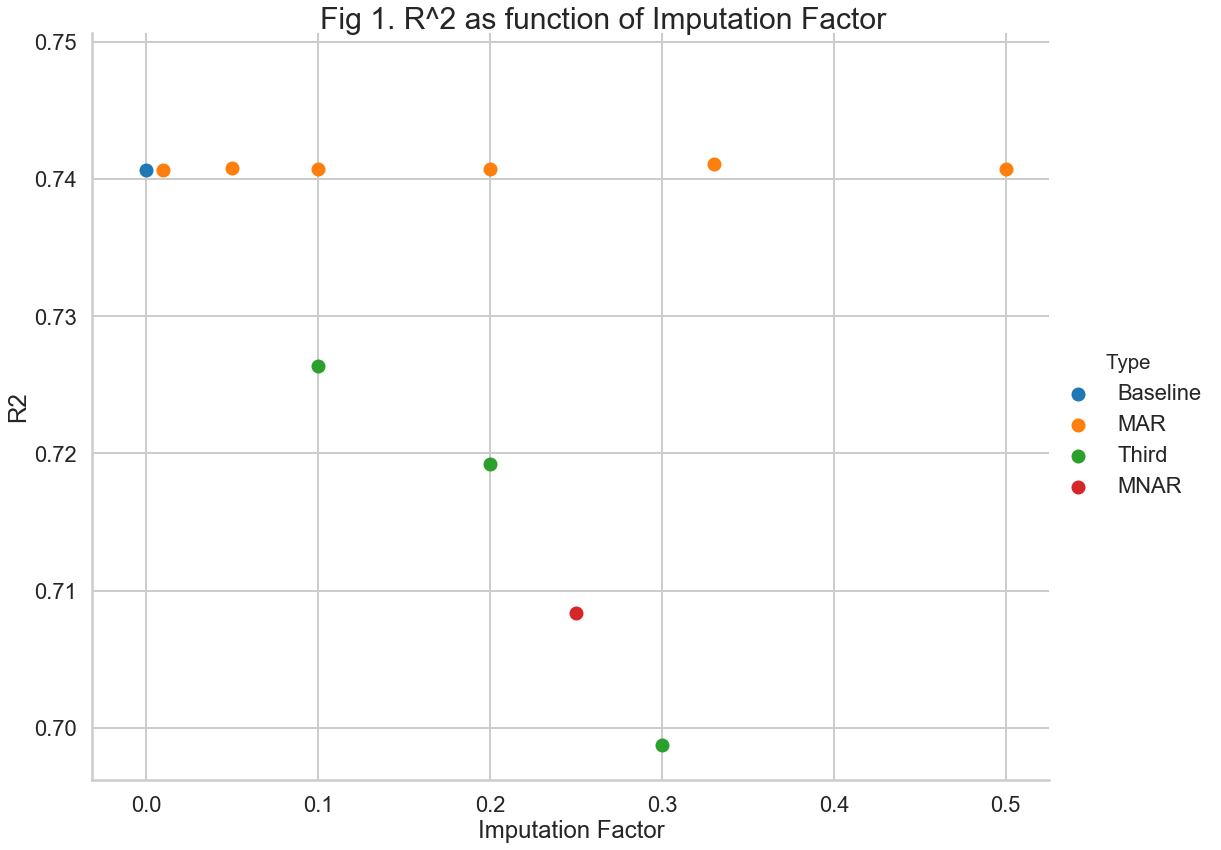

In [62]:
r2plot = sns.FacetGrid(data = results, hue = 'Type', height = 12, aspect = 1.25)
r2plot.map(plt.scatter, 'Imputation Factor', 'R2').add_legend()
r2plot.fig.suptitle('Fig 1. R^2 as function of Imputation Factor', fontsize = 30)
r2plot.fig.subplots_adjust(top = 0.95)

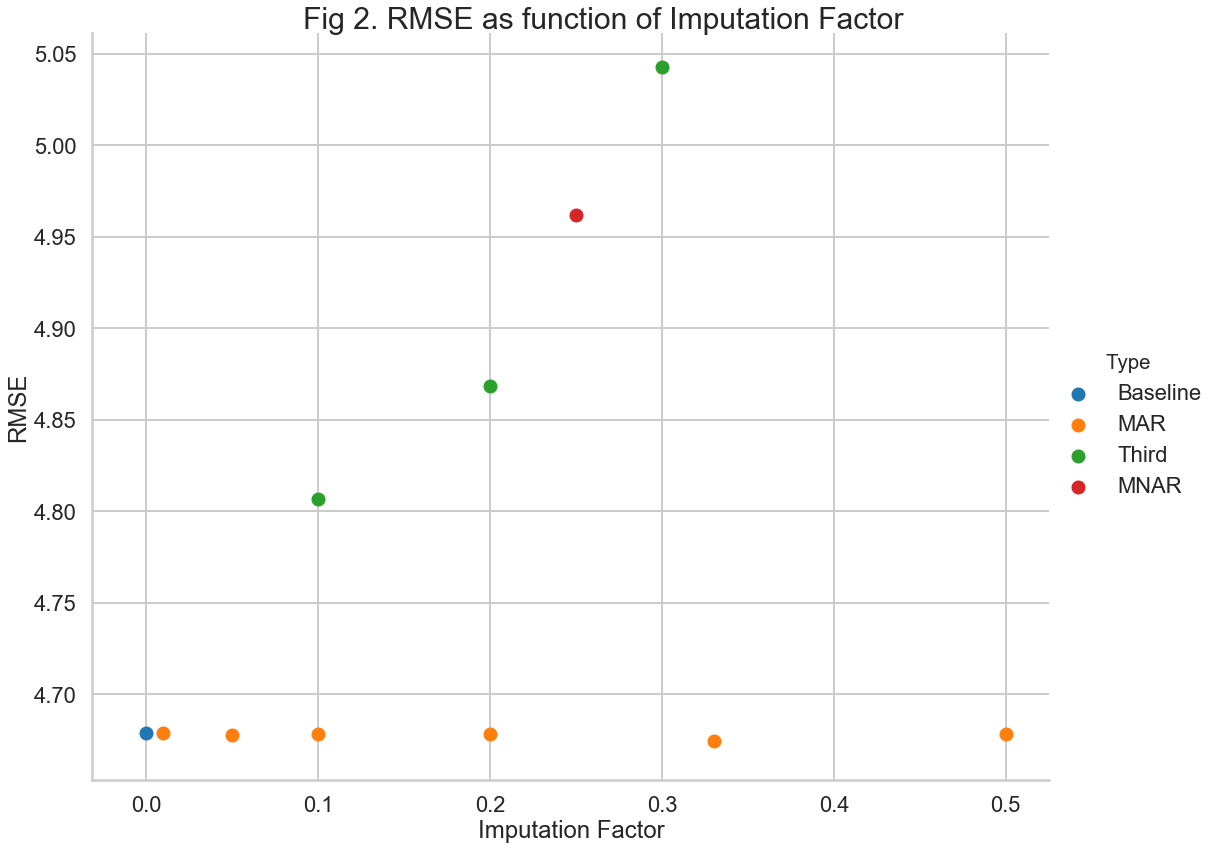

In [64]:
r2plot = sns.FacetGrid(data = results, hue = 'Type', height = 12, aspect = 1.25)
r2plot.map(plt.scatter, 'Imputation Factor', 'RMSE').add_legend()
r2plot.fig.suptitle('Fig 2. RMSE as function of Imputation Factor', fontsize = 30)
r2plot.fig.subplots_adjust(top = 0.95)

# References

1. McKinney, W. (2014), *Python for Data Analysis*, San Francisco, CA: O’Reilly Publishers

2. Tom Rosenstrom (2014), *Some Core Ideas of Imputation for Nonresponse in Surveys*, University of Helsinki